<span style="color:#6D071A; font-size:38px; font-weight:bold">Study on Facial Expression Recognition with Local Binary Patterns Descriptors</span>


**Authors**: Daniel RODRIGUEZ CIOTTI - Julen URCHOEGUIA

**Date**: 2024-04-09 

# Introduction

This project explores the application of Local Binary Patterns (LBP) in the field of facial emotion recognition without the use of Deep Learning.

Our methodology focuses on extracting local texture patterns from facial images with LBP with the aim of reaching a comprehensive representation of the faces.

To validate our approach, evaluations were performed on a benchmarked dataset encompassing varying lighting conditions, poses, and facial expressions. Our method showcased promises, all the more so since it is based on non-deep learning models.
The use of LBP presents a strong basis, as its capacity to capture nuanced facial attributes allows the use of these models in real-world scenarios.


# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from skimage import feature
import os
from tqdm import tqdm
import pandas as pd
import itertools
from imutils import face_utils
import numpy as np
import dlib
import json
import pickle

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# FER2013 Dataset

We want to use LBP descriptors for facial expression recognition. To benchmark our approach we will use the [FER2013 Dataset](https://www.kaggle.com/datasets/msambare/fer2013). This dataset contains more than 30,000 labelled faces in the format 48x48, with 7 different labels (happy, sad, angry, ...). 

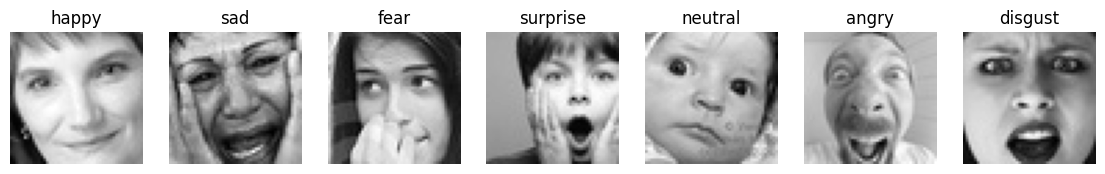

In [3]:
# Let's show one example per class of the FER dataset
data_path = 'data/fer/train/'
classes = os.listdir(data_path)
fig, axes = plt.subplots( ncols=7, figsize=(14, 2))
for i, ax in enumerate(axes):
    image = cv2.imread(data_path + classes[i] + '/' + os.listdir(data_path + classes[i])[0])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ax.imshow(gray, cmap='gray')
    ax.axis('off')
    ax.set_title(classes[i])

# LBP Introduction

Example taken from https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html


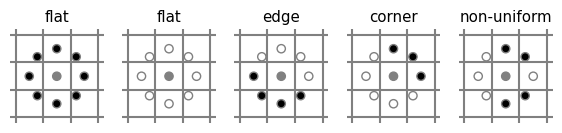

In [4]:
plt.rcParams['font.size'] = 9


def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)


def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0, 0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the pixel grid.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)

    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)


fig, axes = plt.subplots(ncols=5, figsize=(7, 2))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [np.zeros(8),
                   np.ones(8),
                   np.hstack([np.ones(4), np.zeros(4)]),
                   np.hstack([np.zeros(3), np.ones(5)]),
                   [1, 0, 0, 1, 1, 1, 0, 0]]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)

The figure above shows example results with black (or white) representing pixels that are less (or more) intense than the central pixel. When surrounding pixels are all black or all white, then that image region is flat (i.e. featureless). Groups of continuous black or white pixels are considered “uniform” patterns that can be interpreted as corners or edges. If pixels switch back-and-forth between black and white pixels, the pattern is considered “non-uniform”.


The LBP operator produces $2^P$ different output values, corresponding to the $2^P$ different binary patterns that can be formed by the $P$ pixels in the neighbor set. The idea is to compute the output value for every pixel of the image and then using the histograms of these values as a feature vector for the image. Using this "default" method, the feature vector size equals $2^P$ .



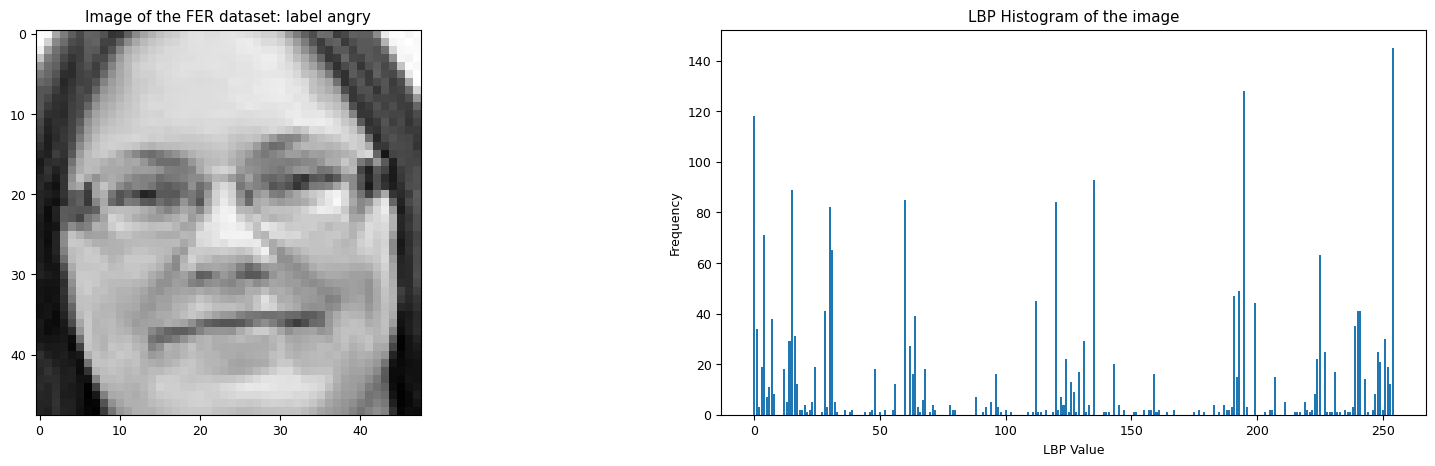

In [5]:
# Load an image and extract LBP features
image = cv2.imread('./data/fer/train/happy/Training_1206.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
lbp = feature.local_binary_pattern(gray, 8, 1, method='default')
lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, lbp.max() + 1), range=(0, lbp.max()))

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# Plot the face image
ax[0].imshow(gray, cmap='gray')
ax[0].set_title('Image of the FER dataset: label angry')

# Plot the LBP image
ax[1].bar(range(len(lbp_hist)), lbp_hist)
plt.xlabel('LBP Value')
plt.ylabel('Frequency')
plt.title('LBP Histogram of the image')
plt.show()

Having a $2^P$ feature vector can be computationally expensive,therefore some improvements were made to quantize information and thus reduce the number of different values output by the operator.

**uniform**: Uniform pattern, exhibiting grayscale and rotation invariance, providing a finer quantization of the angular space. This reduces quantization to $P + 1$ different values.

**nri_uniform**: A variant of the uniform pattern that retains grayscale invariance, but is not rotation invariant. This reduces quantization to P (P − 1) + 2 different values.

# LBP for facial recognition on FER2013 Dataset

## Defining util classes and functions to load and process the data

In [6]:
class LocalBinaryPatterns:
	def __init__(self, radius: float, numPoints: int, method="default"):
		"""_summary_

		Args:
			radius (float): Radius of circle (spatial resolution of the operator).
			numPoints (int): Number of circularly symmetric neighbor set points (quantization of the angular space).
			method (str, optional): Method used to compute LBP hist. Choose between default, uniforme or nri_uniform. Defaults to "default".
		"""		
		self.radius = radius
		self.numPoints = numPoints
		self.method = method

	@property
	def n_bins(self):
		"""Number of bins in the LBP histogram depending on the parameters used."""
		if self.method == "default":
			return 2**self.numPoints
		elif self.method == "uniform":
			return (self.numPoints + 1)
		elif self.method == "nri_uniform":
			return self.numPoints * (self.numPoints - 1) + 2
		else:
			raise NotImplementedError("Method not implemented. Choose between default, uniform or nri_uniform")
	
	def describe(self, image):
		"""Compute the LBP histogram for the image using the parameters specified in the object."""
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method=self.method)
		hist, _ = np.histogram(lbp, bins=np.arange(0, self.n_bins+2), density=True)
		return hist, lbp		

In [7]:
def get_grid_subregions(image: np.ndarray, side_region_nb: int):
    """Function that divides an image into subregions of equal size and returns the coordinates of each subregion and the cropped images.

    Args:
        image (np.ndarray): Array representing the image
        side_region_nb (int): Number of contiguous subregions to divide the image into

    Returns:
        tuple: list of coordinates of each subregion and list of cropped images
    """    
    # Calculate the size of each subregion
    subregion_size = image.shape[0] // side_region_nb
    subregion_coordinates = []
    cropped_images = []

    for i in range(side_region_nb):
        for j in range(side_region_nb):
            # Calculate the start and end coordinates of the subregion
            start_x = i * subregion_size
            end_x = start_x + subregion_size
            start_y = j * subregion_size
            end_y = start_y + subregion_size

            # Append the subregion coordinates to the list
            subregion_coordinates.append((start_x, start_y, end_x, end_y))

            # Crop the image using the subregion coordinates
            cropped_image = image[start_y:end_y, start_x:end_x]
            cropped_images.append(cropped_image)

    return subregion_coordinates, cropped_images


def get_region(image: np.ndarray, region_shape: tuple, step_size: int):
    """Function that creates a sliding window over an image and returns the subregions and their coordinates.
    Args:
        image (np.ndarray): Array representing the image
        region_shape (tuple): Shape of the window
        step_size (int): Step size of the sliding window

    Returns:
        tuple: list of subregions and list of coordinates of each subregion
    """    
    subregions = []
    coordinates = []
    height, width = image.shape[:2]
    region_height, region_width = region_shape
    
    for y in range(0, height - region_height + 1, step_size):
        for x in range(0, width - region_width + 1, step_size):
            subregion = image[y:y+region_height, x:x+region_width]
            subregions.append(subregion)
            coordinates.append((x, y, x+region_width, y+region_height))
    
    return subregions, coordinates


def chi_square_distance(hist1: np.ndarray, hist2: np.ndarray):
    """Function that computes the chi square distance between two histograms."""
    return np.sum((hist1 - hist2)**2 / (hist1 + hist2 + 1e-10))

In [8]:
class Dataset():
    """Dataset class to load and process the images of faces with LBP."""    
    def __init__(self, 
                 path: str, 
                 radius: float, 
                 numPoints: int, 
                 method: str,
                 max_samples: int, 
                 path_predictor: str = None, 
                 subregion_type: str = "whole", 
                 num_subregions: int = None, 
                 list_subregions: list = None):
        """
        Args:
            path (str): Path to the high level folder containing the images (e.g: data/train/).
            radius (float): Radius of circle (spatial resolution of the operator).
            numPoints (int): Number of circularly symmetric neighbor set points (quantization of the angular space). 
            method (str): Method used to compute LBP hist. Choose between default, uniforme or nri_uniform.
            max_samples (int): Number of samples max to load.
            subregion_type (str, optional): . Whether to compute LBP hist over 
            - "whole": the whole image at once
            - "manual": a list of predefined ROI
            - "grid": a grid of subregions
            - "face_parts": specific regions of the face detected thanks to predictor

            path_predictor (str, optional): Path to face parts predictor. Specify if using subregion_type == "face_parts". Defaults to None.
            num_subregions (int, optional): Number of subregions for the grid. Specify if using subregion_type == "grid". Defaults to None.
            list_subregions (list, optional): List of ROI. Specify if using subregion_type == "manual" Defaults to None.
        """    
        self.path = path
        self.max_samples = max_samples
        self.subregion_type = subregion_type
        self.num_subregions = num_subregions
        self.lbp = LocalBinaryPatterns(radius, numPoints, method)
        self.data = []
        self.labels = []
        self.feature_vectors = []
        self.predictor = dlib.shape_predictor(path_predictor) if path_predictor else None
        self.list_subregions = list_subregions

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return {"image_arr": self.data[index], "label":self.labels[index], "feature_vector": self.feature_vectors[index]}
    
    def load_data(self):
        """Loads the images and compute the LBP histograms."""
        for emotion in (os.listdir(self.path)):
            for image in (os.listdir(os.path.join(self.path, emotion))[:self.max_samples]):
                img = Image.open(os.path.join(self.path, emotion, image))
                img = np.asarray(img)
                self.data.append(img)
                self.labels.append(emotion)
                if self.subregion_type == "whole":
                    hist, _ = self.lbp.describe(img)

                elif self.subregion_type == "grid":
                    _, cropped_subregions = get_grid_subregions(img, self.num_subregions)
                    hist = np.hstack([self.lbp.describe(subregion)[0] for subregion in cropped_subregions]).reshape(-1)

                elif self.subregion_type == "face_parts":
                    face_parts = self.predictor(img, dlib.rectangle(0, 0, img.shape[0], img.shape[1]))
                    face_parts = face_utils.shape_to_np(face_parts)
                    hist_regions = []

                    for (_, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
                        (x, y, w, h) = cv2.boundingRect(np.array([face_parts[i:j]]))
                        roi = img[y:y + h, x:x + w]

                        if roi.shape[0] != 0 and roi.shape[1] != 0:
                            hist_region = self.lbp.describe(roi)[0]
                            hist_regions.append(hist_region)
                        else:
                            len_vector = self.lbp.n_bins + 1
                            hist_region = np.zeros(len_vector)
                            hist_regions.append(hist_region)

                    hist = np.hstack([hist_region for hist_region in hist_regions]).reshape(-1)

                elif self.subregion_type == "manual":
                    hist_regions = []
                    for subregion in self.list_subregions:
                        x_start, y_start, x_end, y_end = subregion
                        roi = img[y_start:y_end, x_start:x_end]
                        hist_region = self.lbp.describe(roi)[0]
                        hist_regions.append(hist_region)
                    hist = np.hstack([hist_region for hist_region in hist_regions]).reshape(-1)

                else:
                    raise NotImplementedError("Method not implemented. Choose between all, grid, face_parts or manual.")
                
                self.feature_vectors.append(hist)
                  

In [9]:
PATH_TRAIN = './data/fer/train/'
PATH_TEST = './data/fer/test/'
MAX_SAMPLES_TRAIN = 500
MAX_SAMPLES_TEST = 125
PARAMS_SVC = {"default": {"C": 100, "kernel": "rbf"}, "uniform": {"C": 100, "kernel": "linear"}, "nri_uniform": {"C": 10, "kernel": "rbf"}}

## Approach 1: Compute LBP Histograms over the whole image at once

In the first approach undertaken for our task of facial expression classification, the Local Binary Patterns (LBP) operator is applied to the entire image, generating a histogram used as input for a 7-class Support Vector Classifier (SVC). The SVC, a powerful tool for data classification in Computer Vision, implicitly maps data to a higher-dimensional space, identifying an optimal hyperplane for separation.

In [26]:
train_dataset = Dataset(PATH_TRAIN, max_samples=MAX_SAMPLES_TRAIN, radius=2, numPoints=12, method="default", subregion_type="whole")
train_dataset.load_data()
X_train, y_train = train_dataset.feature_vectors, train_dataset.labels

In [27]:
test_dataset = Dataset(PATH_TEST, max_samples=MAX_SAMPLES_TEST, radius=2, numPoints=12, method="default", subregion_type="whole")
test_dataset.load_data()
X_test, y_test = test_dataset.feature_vectors, test_dataset.labels

In [28]:
print("Number of training samples: ", len(X_train))
print("Number of testing samples: ", len(X_test))
print("Length of feature vector: ", len(X_train[0]))

Number of training samples:  3436
Number of testing samples:  861
Length of feature vector:  4097


In [29]:
svc = SVC(class_weight='balanced', **PARAMS_SVC[train_dataset.lbp.method])
svc.fit(X_train, y_train)

SVC(C=100, class_weight='balanced')

In [12]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

       angry       0.24      0.27      0.25       125
     disgust       0.42      0.50      0.46       111
        fear       0.19      0.18      0.18       125
       happy       0.36      0.35      0.35       125
     neutral       0.28      0.25      0.26       125
         sad       0.27      0.24      0.25       125
    surprise       0.40      0.40      0.40       125

    accuracy                           0.31       861
   macro avg       0.31      0.31      0.31       861
weighted avg       0.31      0.31      0.31       861



Text(34.22222222222222, 0.5, 'True')

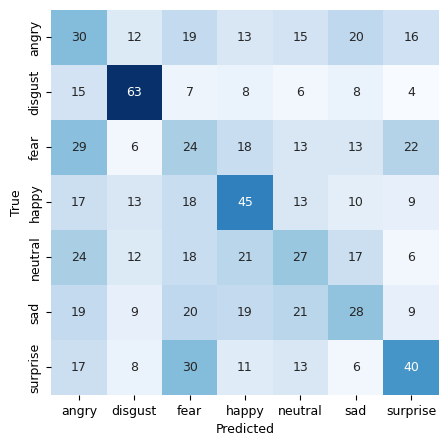

In [30]:
# Confusion matrix plot
cm = confusion_matrix(y_test, svc.predict(X_test))
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(7) + 0.5, ["angry", "disgust", "fear", "happy", "neutral","sad", "surprise"])
plt.yticks(np.arange(7) + 0.5, ["angry", "disgust", "fear", "happy", "neutral","sad", "surprise"])
plt.xlabel('Predicted') 
plt.ylabel('True')

In [31]:
os.makedirs("./results_basic_approach", exist_ok=True)
pickle.dump(svc, open("./results_basic_approach/svc.pkl", "wb"))

### Tuning the hyperparameters for this method

In [32]:
# Parameters that will be tested during the grid search
list_radius = [1, 1.5, 2]
list_numPoints = [8, 12, 16]
list_method = ["default", "uniform", "nri_uniform"]

In [33]:
experiment_tracking_df = pd.DataFrame(columns=['id','radius', 'numPoints', 'method', "kwargs_param", 'macro_f1_score', "accuracy"])

In [36]:
id_experiment = 1
grid = itertools.product(list_radius, list_numPoints, list_method)
for radius, num_point, method in tqdm(grid, total=len(list_radius)*len(list_numPoints)*len(list_method)):
    # Skip some combinations of parameters that are too computationally expensive
    if method == "default" and num_point == 16:
        continue
    
    # Load data
    train_dataset = Dataset(PATH_TRAIN, max_samples=MAX_SAMPLES_TRAIN, radius=radius, numPoints=num_point, method=method, subregion_type="whole")
    train_dataset.load_data()
    X_train, y_train = train_dataset.feature_vectors, train_dataset.labels
    test_dataset = Dataset(PATH_TEST, max_samples=MAX_SAMPLES_TEST, radius=radius, numPoints=num_point, method=method, subregion_type="whole")
    test_dataset.load_data()
    X_test, y_test = test_dataset.feature_vectors, test_dataset.labels

    # Train and predict
    svc = SVC(class_weight='balanced', **PARAMS_SVC[method])
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    macro_f1_score = f1_score(y_test, y_pred, average='macro')
    accuracy = svc.score(X_test, y_test)

    # Save al the classification report as txt file and save the major metrics in a dataframe
    report = classification_report(y_test, y_pred)
    with open(f"./results_basic_approach/{id_experiment}.txt", "w") as f:
        f.write(report)
    experiment_tracking_df = pd.concat([experiment_tracking_df, 
                                        pd.DataFrame({"id":id_experiment, 
                                                      'radius': radius, 
                                                      'numPoints': num_point, 
                                                      'method': method, 
                                                      "kwargs_param": str(PARAMS_SVC[method]), 
                                                      'macro_f1_score': macro_f1_score, 
                                                      "accuracy": accuracy}, index=[0])], 
                                        ignore_index=True)
    id_experiment += 1

100%|██████████| 27/27 [02:00<00:00,  4.48s/it]


In [37]:
experiment_tracking_df = experiment_tracking_df.sort_values(by="macro_f1_score", ascending=False)

In [38]:
experiment_tracking_df.head(10)

id radius numPoints       method                 kwargs_param  \
21  17      2         8      default  {'C': 100, 'kernel': 'rbf'}   
24  20      2        12      default  {'C': 100, 'kernel': 'rbf'}   
16  12    1.5        12      default  {'C': 100, 'kernel': 'rbf'}   
13   9    1.5         8      default  {'C': 100, 'kernel': 'rbf'}   
8    4      1        12      default  {'C': 100, 'kernel': 'rbf'}   
23  19      2         8  nri_uniform   {'C': 10, 'kernel': 'rbf'}   
18  14    1.5        12  nri_uniform   {'C': 10, 'kernel': 'rbf'}   
15  11    1.5         8  nri_uniform   {'C': 10, 'kernel': 'rbf'}   
2    3      1         8  nri_uniform   {'C': 10, 'kernel': 'rbf'}   
7    3      1         8  nri_uniform   {'C': 10, 'kernel': 'rbf'}   

    macro_f1_score  accuracy  
21        0.302457  0.301974  
24        0.301527  0.298490  
16        0.288426  0.290360  
13        0.278564  0.281069  
8         0.278169  0.279907  
23        0.276833  0.286876  
18        0.265173  0.277584  
15        0.263418  0.276423  
2         0.259951  0.269454  
7         0.259951  0.269454

In [39]:
experiment_tracking_df.to_csv("./results_basic_approach/experiment_tracking.csv", index=False)

We can see that the best method is the default one, but this methods takes a lot of time (input vector size 2**Numpoints). Thus nri_uniform can be a good trade off.

## Approach 2: LBP Histograms concatenation over image divided into a grid.

Face images can be seen as a composition of micro-patterns which can be effectively described by the LBP histograms. 

Therefore, it is intuitive to use LBP features to represent face images. A LBP histogram computed over the whole face image encodes only the occurrences of the micro-patterns without any indication about their locations. To also consider shape information of faces, face images were equally divided into small regions. The LBP features extracted from each sub-region are concatenated into a single, spatially enhanced feature histogram

We will restrain to nri_uniform method since computing a exhaustive LBP histogram for every subregion will result in a feature vector with a too high dimension. We will also consider the case of a small radius (= 1 pixel) since the cells correspond to small regions of space

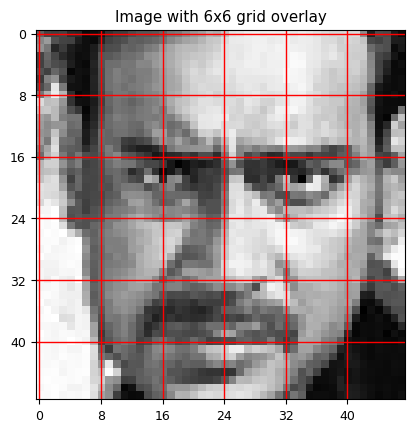

In [10]:
random_img = Image.open('./data/fer/train/angry/Training_426842.jpg')
random_img = np.asarray(random_img)
plt.imshow(random_img, cmap='gray')
plt.grid(True, which='both', color='red', linewidth=1)
plt.xticks(range(0, random_img.shape[1], random_img.shape[1] // 6))
plt.yticks(range(0, random_img.shape[0], random_img.shape[0] // 6))
plt.title('Image with 6x6 grid overlay')
plt.show()

In [44]:
train_dataset = Dataset(PATH_TRAIN, 
                        max_samples=None, 
                        radius=1, 
                        numPoints=4, 
                        method="nri_uniform", 
                        subregion_type="grid",
                        num_subregions=6)
train_dataset.load_data()
X_train, y_train = train_dataset.feature_vectors, train_dataset.labels

In [45]:
test_dataset = Dataset(PATH_TEST, 
                       max_samples=None, 
                       radius=1,
                       numPoints=4, 
                       method="nri_uniform", 
                       subregion_type="grid", 
                       num_subregions=6)
test_dataset.load_data()
X_test, y_test = test_dataset.feature_vectors, test_dataset.labels

In [46]:
print("Number of training samples: ", len(X_train))
print("Number of testing samples: ", len(X_test))
print("Length of feature vector: ", len(X_train[0]))

Number of training samples:  28709
Number of testing samples:  7178
Length of feature vector:  540


In [47]:
# Before running this cell, take into account the execution time (around 8 minutes)
svc = SVC(class_weight='balanced', **PARAMS_SVC["nri_uniform"])
svc.fit(X_train, y_train)

SVC(C=10, class_weight='balanced')

In [48]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

       angry       0.41      0.41      0.41       958
     disgust       0.92      0.43      0.59       111
        fear       0.45      0.41      0.43      1024
       happy       0.66      0.74      0.70      1774
     neutral       0.46      0.47      0.46      1233
         sad       0.41      0.41      0.41      1247
    surprise       0.74      0.65      0.69       831

    accuracy                           0.53      7178
   macro avg       0.58      0.50      0.53      7178
weighted avg       0.53      0.53      0.53      7178



Text(34.22222222222222, 0.5, 'True')

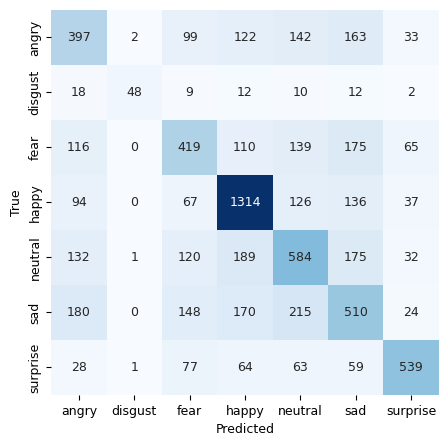

In [49]:
# Confusion matrix plot
cm = confusion_matrix(y_test, svc.predict(X_test))
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(7) + 0.5, ["angry", "disgust", "fear", "happy", "neutral","sad", "surprise"])
plt.yticks(np.arange(7) + 0.5, ["angry", "disgust", "fear", "happy", "neutral","sad", "surprise"])
plt.xlabel('Predicted') 
plt.ylabel('True')

In [50]:
os.makedirs("./results_grid_division", exist_ok=True)
pickle.dump(svc, open("./results_grid_division/svc.pkl", "wb"))

### Tuning the hyperparameters for this method

In [24]:
# Parameters that will be tested during the grid search
list_num_subregions = [4, 6, 8, 12]
list_numPoints = [4, 8, 12]

In [25]:
experiment_tracking_df = pd.DataFrame(columns=['id','num_subregions', 'numPoints', "model", "kwargs_param", 'macro_f1_score', "accuracy"])

In [26]:
id_experiment = 1
for num_subregions, num_point in tqdm(itertools.product(list_num_subregions, list_numPoints), total=len(list_num_subregions)*len(list_numPoints)):
    # Skip some combinations of parameters that are too computationally expensive
    if num_point**2*num_subregions**2 > 3000:
        continue

    # Load data
    train_dataset = Dataset(PATH_TRAIN, 
                            max_samples=MAX_SAMPLES_TRAIN, 
                            radius=1, 
                            numPoints=num_point, 
                            method="nri_uniform", 
                            subregion_type="grid", 
                            num_subregions=num_subregions)
    train_dataset.load_data()
    X_train, y_train = train_dataset.feature_vectors, train_dataset.labels

    test_dataset = Dataset(PATH_TEST, 
                           max_samples=MAX_SAMPLES_TEST, 
                           radius=1, 
                           numPoints=num_point, 
                           method="nri_uniform", 
                           subregion_type="grid", 
                           num_subregions=num_subregions)
    test_dataset.load_data()
    X_test, y_test = test_dataset.feature_vectors, test_dataset.labels

    # Train and predict
    svc = SVC(class_weight='balanced', **PARAMS_SVC["nri_uniform"])
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    macro_f1_score = f1_score(y_test, y_pred, average='macro')
    accuracy = svc.score(X_test, y_test)
    report = classification_report(y_test, y_pred)

    # Save all the classification report as txt file and save the major metrics in a dataframe
    with open(f"./results_grid_division/{id_experiment}.txt", "w") as f:
        f.write(report)
    experiment_tracking_df = pd.concat([experiment_tracking_df, 
                                        pd.DataFrame({"id":id_experiment, 
                                                      'num_subregions': num_subregions, 
                                                      'numPoints': num_point, 
                                                      "model": "SVM", 
                                                      "kwargs_param": str(PARAMS_SVC["nri_uniform"]), 
                                                      'macro_f1_score': macro_f1_score, 
                                                      "accuracy": accuracy}, index=[0])], 
                                        ignore_index=True)
    id_experiment += 1

  0%|          | 0/12 [00:00<?, ?it/s]/var/folders/_s/grxhyczx135dcrhc7pzfhkxr0000gn/T/ipykernel_65755/3806718215.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  experiment_tracking_df = pd.concat([experiment_tracking_df,
100%|██████████| 12/12 [01:40<00:00,  8.42s/it]


In [27]:
experiment_tracking_df = experiment_tracking_df.sort_values(by="macro_f1_score", ascending=False)

In [28]:
experiment_tracking_df.head(10)

id num_subregions numPoints model                kwargs_param  \
4  5              6         8   SVM  {'C': 10, 'kernel': 'rbf'}   
3  4              6         4   SVM  {'C': 10, 'kernel': 'rbf'}   
0  1              4         4   SVM  {'C': 10, 'kernel': 'rbf'}   
2  3              4        12   SVM  {'C': 10, 'kernel': 'rbf'}   
1  2              4         8   SVM  {'C': 10, 'kernel': 'rbf'}   
6  7             12         4   SVM  {'C': 10, 'kernel': 'rbf'}   
5  6              8         4   SVM  {'C': 10, 'kernel': 'rbf'}   

   macro_f1_score  accuracy  
4        0.417398  0.408827  
3        0.397729  0.392567  
0        0.390427  0.385598  
2        0.389294  0.387921  
1        0.384617  0.382114  
6        0.382886  0.379791  
5        0.378683  0.375145

In [29]:
experiment_tracking_df.to_csv("./results_grid_division/experiment_tracking.csv", index=False)

## Approach 3: Learning best region of interest (ROI) using weak learners

We saw in the previous sections that the classifier results are very sensitive to the image regions on which we calculate our LBP histograms. 

To try to fit our needs as closely as possible and avoid large feature vectors, we'd like to learn which face ROIs will weigh most heavily in the classifier's decision. To do this:
- we'll generate a very large number of ROIs by testing different window shapes and scales, which we'll pass over the entire image. 

- we'll then train weaks classifiers based solely on one ROIs each time, and see which weaks classifiers perform best. These will then be associated with a ROI with high discriminating power. 

In [14]:
# Defining some parameters
step_size_sliding_window = 2
region_sizes = np.array([4, 8, 12, 16])
window_shapes = list(itertools.product(region_sizes, region_sizes))
len_histo = 15

In [15]:
count_regions = 0
for region_shape in window_shapes:
    subregions, coordinates = get_region(random_img, region_shape, 2)
    count_regions += len(subregions)
print("Number of subregions that will be tested: ", count_regions)
print("That means we will have to compute ", count_regions, " LBP histograms of", len_histo, " bins each per image.")

Number of subregions that will be tested:  6400
That means we will have to compute  6400  LBP histograms of 15  bins each per image.


In [47]:
labels = []
feature_vectors = []

# We are going to use 4 points to reduce the number of bins in the histogram to 15
lbp = LocalBinaryPatterns(1, 4, "nri_uniform")

# Keep a mapping between the index of the subregion and its coordinates
mapping_index_region = {}

In [48]:
for emotion in (os.listdir(PATH_TRAIN)):
    for image in tqdm(os.listdir(os.path.join(PATH_TRAIN, emotion))[:MAX_SAMPLES_TRAIN]):
        img = Image.open(os.path.join(PATH_TRAIN, emotion, image))
        img = np.asarray(img)
        labels.append(emotion)
        index = 0
        all_hist = []
        for subregion_shape in window_shapes:
            subregions, subregions_coor = get_region(img, region_shape=subregion_shape, step_size=step_size_sliding_window)
            for subregion, subregion_coor in zip(subregions, subregions_coor):
                hist_local = lbp.describe(subregion)[0]
                mapping_index_region[(index*len(hist_local),(index+1)*len(hist_local)-1)] = subregion_coor
                index += 1
                all_hist.append(hist_local)
        hist = np.array(all_hist).flatten()
        feature_vectors.append(hist)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 436/436 [01:36<00:00,  4.53it/s]


In [49]:
os.makedirs("./results_roi_learning", exist_ok=True)
np.save("./results_roi_learning/labels.npy", labels)

In [50]:
np.save("./results_roi_learning/feature_vectors.npy", feature_vectors)

In [52]:
mapping_index_region_parsed = {}
for key, value in mapping_index_region.items():
    mapping_index_region_parsed[str(key)] = str(value)
with open("./results_roi_learning/mapping_index_region.json", "w") as f:
    json.dump(mapping_index_region_parsed, f)

As the previous step took a long time, we recorded the output of the local transformation step. 

In [86]:
feature_vectors = np.load("./results_roi_learning/feature_vectors.npy")
labels = np.load("./results_roi_learning/labels.npy")
with open("./results_roi_learning/mapping_index_region.json", "rb") as f:
    mapping_index_region_parsed = json.load(f)
mapping_index_region = {}
for key, value in mapping_index_region_parsed.items():
    mapping_index_region[eval(key)] = eval(value)

In [54]:
X_train = feature_vectors
y_train = labels

We create first a histogram template for every ROI for every emotion by averaging the histogrammes of all the observations of the class.

We will thus end up having 7 templates, each of them composed of 6400 histograms of 15 bins as features.


In [55]:
X_template_by_emotion = dict()

In [56]:
for emotion in tqdm(os.listdir(PATH_TRAIN)):
    X_emotion = np.array([X_obs for X_obs, y_obs in zip(X_train, y_train) if y_obs == emotion])
    X_template = np.mean(X_emotion, axis=0)

    # Slice the array every 15 index to separate the histograms of each ROI
    X_template = np.array([X_template[i:i+len_histo] for i in range(0, len(X_template), len_histo)])
    X_template_by_emotion[emotion] = X_template

100%|██████████| 7/7 [00:00<00:00,  8.76it/s]


We create **X_train_by_feature** which is a list of of matrices. Every matrix represents the histo of a single region for all the observations of the class.

Thus every matrix has a shape NxH:
- N: representing the number of observations in our dataset for this particular emotion 
- H: representing the number of bins in the histogramme (here 15)

And the list contains 6400 matrices because we picked 6400 different subregions.

In [57]:
X_train_by_feature = [[X_train[j][i:i + 15] for j in range(len(X_train))] for i in range(0, len(X_train[0]), len_histo)]

Now we'll take the ROIs one by one, and proceed to assign all observations to the closest template using a weak KNN based solely on that ROI. For each of these ROIs, we'll calculate the score of our weak classifier, which can then be used to rank our ROIs by discrimination power.

In [58]:
knn = KNeighborsClassifier(n_neighbors=1, metric=chi_square_distance)
score_roi = dict()

In [59]:
for index_roi in tqdm(range(count_regions)):
    # Get the templates of the current ROI for each emotion
    template_features = np.array([X_template_by_emotion[emotion][index_roi] for emotion in X_template_by_emotion.keys()])
    label_templates = np.array([emotion for emotion in X_template_by_emotion.keys()])
    knn.fit(template_features, label_templates)

    # Get the ROI feature for all the observations
    feature_vectors = np.array(X_train_by_feature[index_roi])
    labels = np.array(y_train)

    # Predict the emotion of the ROI
    preds = knn.predict(feature_vectors)
    
    # Compute error of every weak classifier and store it with the coordinates of the ROI
    score = accuracy_score(y_true=labels, y_pred=preds)
    coord_roi = list(mapping_index_region.values())[index_roi]
    score_roi[coord_roi] = score

100%|██████████| 6400/6400 [13:14<00:00,  8.05it/s]


In [60]:
score_roi = {k: v for k, v in sorted(score_roi.items(), key=lambda item: item[1], reverse=True)}

In [61]:
# Print the 10 best ROI
for i, (k, v) in enumerate(score_roi.items()):
    if i == 10:
        break
    print(f"ROI {i+1}: {k} with score {v}")

ROI 1: (14, 32, 30, 44) with score 0.24941792782305006
ROI 2: (16, 32, 32, 48) with score 0.24650756693830034
ROI 3: (20, 32, 36, 48) with score 0.24621653084982537
ROI 4: (16, 32, 32, 44) with score 0.24534342258440048
ROI 5: (24, 34, 36, 46) with score 0.24330616996507567
ROI 6: (24, 32, 36, 44) with score 0.2430151338766007
ROI 7: (26, 34, 34, 46) with score 0.24243306169965076
ROI 8: (24, 30, 32, 46) with score 0.24243306169965076
ROI 9: (10, 32, 22, 48) with score 0.24243306169965076
ROI 10: (16, 32, 28, 48) with score 0.2421420256111758


Save the ROIs as a JSON file

In [62]:
os.makedirs("./results_roi_learning", exist_ok=True)
with open("./results_roi_learning/score_roi.json", "w") as f:
    json.dump(str(score_roi), f)

Let's visualize which ROI are the most discriminatives for this dataset now

In [63]:
with open("./results_roi_learning/score_roi.json", "rb") as f:
    score_roi = json.load(f)
    score_roi = eval(score_roi)

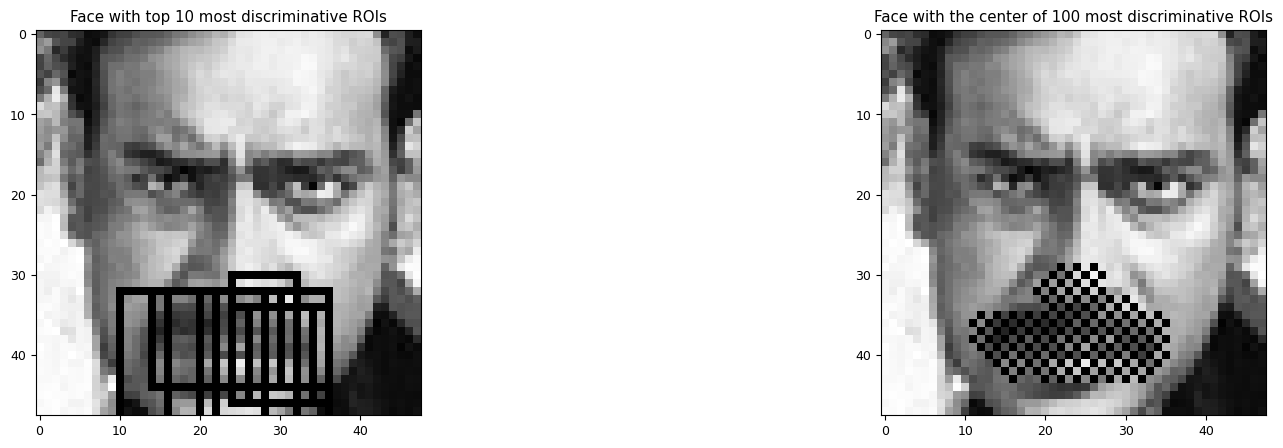

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
image = random_img.copy()
# Plot the face image and the bounding box of the top 10 most discriminative ROIs
for (start_x, start_y, end_x, end_y) in list(score_roi.keys())[:10]:
    cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 1)

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Face with top 10 most discriminative ROIs")

# Plot the center of top 50 ROIs 
image_circle = random_img.copy()
for (start_x, start_y, end_x, end_y) in list(score_roi.keys())[:200]:
    center_bbox = ((start_x+end_x)//2, (start_y+end_y)//2)
    cv2.circle(image_circle, center_bbox, 1, (0, 255, 0), 1)

ax[1].imshow(image_circle, cmap='gray')
ax[1].set_title("Face with the center of 100 most discriminative ROIs")
plt.show()	

### Training a new model with the concatenation of LBP histo computed on every 10 best ROIs

In [67]:
N_TOP_ROI = 10

In [68]:
train_dataset = Dataset(PATH_TRAIN, 
                        max_samples=None, 
                        radius=1, 
                        numPoints=4, 
                        method="nri_uniform", 
                        subregion_type="manual", 
                        list_subregions=list(score_roi.keys())[:N_TOP_ROI])
train_dataset.load_data()
X_train, y_train = train_dataset.feature_vectors, train_dataset.labels

test_dataset = Dataset(PATH_TEST, 
                       max_samples=None, 
                       radius=1, 
                       numPoints=4, 
                       method="nri_uniform", 
                       subregion_type="manual", 
                       list_subregions=list(score_roi.keys())[:N_TOP_ROI])
test_dataset.load_data()
X_test, y_test = test_dataset.feature_vectors, test_dataset.labels

In [69]:
print("Number of training samples: ", len(X_train))
print("Number of testing samples: ", len(X_test))
print("Length of feature vector: ", len(X_train[0]))

Number of training samples:  28709
Number of testing samples:  7178
Length of feature vector:  150


In [70]:
svc = SVC(class_weight='balanced', **PARAMS_SVC["nri_uniform"])
svc.fit(X_train, y_train)

SVC(C=10, class_weight='balanced')

In [71]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

       angry       0.28      0.32      0.30       958
     disgust       0.38      0.34      0.36       111
        fear       0.31      0.29      0.30      1024
       happy       0.62      0.63      0.62      1774
     neutral       0.40      0.42      0.41      1233
         sad       0.37      0.30      0.33      1247
    surprise       0.53      0.56      0.54       831

    accuracy                           0.43      7178
   macro avg       0.41      0.41      0.41      7178
weighted avg       0.43      0.43      0.43      7178



Text(71.72222222222221, 0.5, 'True')

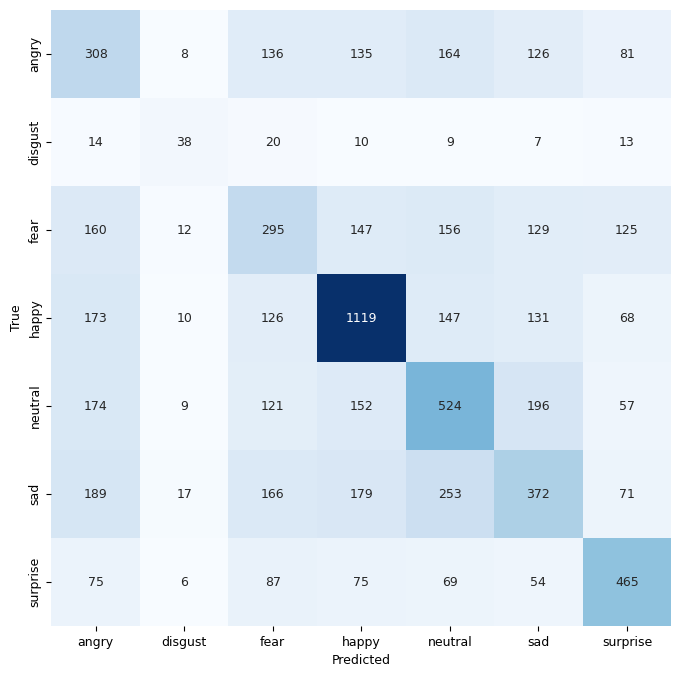

In [72]:
# Confusion matrix plot
cm = confusion_matrix(y_test, svc.predict(X_test))
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(7) + 0.5, ["angry", "disgust", "fear", "happy", "neutral","sad", "surprise"])
plt.yticks(np.arange(7) + 0.5, ["angry", "disgust", "fear", "happy", "neutral","sad", "surprise"])
plt.xlabel('Predicted')
plt.ylabel('True')

### Try to learn the ROI specificly to every emotion 

We can easily guess that the most important regions in the detection of an emotion will differ from one class to another. To improve on the previous results, we could learn the top ROIs for each class separately by binarizing the problem 7 times (classifying one vs all). We would then take the concatenation of the top ROIs for each class. 

In [11]:
feature_vectors = np.load("./results_roi_learning/feature_vectors.npy")
labels = np.load("./results_roi_learning/labels.npy")
with open("./results_roi_learning/mapping_index_region.json", "rb") as f:
    mapping_index_region_parsed = json.load(f)
mapping_index_region = {}
for key, value in mapping_index_region_parsed.items():
    mapping_index_region[eval(key)] = eval(value)

In [12]:
X_train = feature_vectors
y_train = labels

In [90]:
X_template_by_emotion = dict()
for emotion in tqdm(os.listdir(PATH_TRAIN)):
    X_template_by_emotion[emotion] = dict()
    X_emotion = np.array([X_obs for X_obs, y_obs in zip(X_train, y_train) if y_obs == emotion])
    X_other = np.array([X_obs for X_obs, y_obs in zip(X_train, y_train) if y_obs != emotion])
    X_template = np.mean(X_emotion, axis=0)
    X_other_template = np.mean(X_other, axis=0)

    # Slice the array every 15 index to separate the histograms of each ROI    
    X_template = np.array([X_template[i:i+len_histo] for i in range(0, len(X_template), len_histo)])
    X_other_template = np.array([X_other_template[i:i+len_histo] for i in range(0, len(X_other_template), len_histo)])
    X_template_by_emotion[emotion]["emotion_template"] = X_template
    X_template_by_emotion[emotion]["avg_other_class_template"] = X_other_template

100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


In [91]:
score_roi_by_emotion = dict()

In [93]:
for emotion in os.listdir(PATH_TRAIN):
    X_train_by_feature = [[X_train[j][i:i + 15] for j in range(len(X_train))] for i in range(0, len(X_train[0]), len_histo)]
    knn = KNeighborsClassifier(n_neighbors=1, metric=chi_square_distance)
    score_roi_by_emotion[emotion] = dict()
    for index_roi in tqdm(range(count_regions)):
        # Get the templates of the current ROI for each emotion
        template_features = np.array([X_template_by_emotion[emotion]["emotion_template"][index_roi], X_template_by_emotion[emotion]["avg_other_class_template"][index_roi]])
        label_templates = np.array([emotion, "other"])
        knn.fit(template_features, label_templates)

        # Get the ROI feature for all the observations
        feature_vectors = np.array(X_train_by_feature[index_roi])
        labels = [emotion if label == emotion else "other" for label in y_train]

        # Predict the emotion of the ROI
        preds = knn.predict(feature_vectors)
        
        # Compute error of every weak classifier and store it with the coordinates of the ROI
        score = f1_score(y_true=labels, y_pred=preds, average='macro')
        coord_roi = list(mapping_index_region.values())[index_roi]
        score_roi_by_emotion[emotion][coord_roi] = score
    del X_train_by_feature

100%|██████████| 6400/6400 [07:13<00:00, 14.76it/s]


In [16]:
X_train_by_feature = [[X_train[j][i:i + 15] for j in range(len(X_train))] for i in range(0, len(X_train[0]), len_histo)]

In [95]:
for emotion in score_roi_by_emotion.keys():
    score_roi_by_emotion[emotion] = {k: v for k, v in sorted(score_roi_by_emotion[emotion].items(), key=lambda item: item[1], reverse=True)}

In [96]:
for emotion in score_roi_by_emotion.keys():
    print(f"Emotion: {emotion}")
    for i, (k, v) in enumerate(score_roi_by_emotion[emotion].items()):
        if i == 10:
            break
        print(f"ROI {i+1}: {k} with score {v}")
    print("")

Emotion: happy
ROI 1: (24, 34, 40, 42) with score 0.5716952910943813
ROI 2: (26, 34, 38, 42) with score 0.571312243309988
ROI 3: (22, 32, 38, 44) with score 0.5706930157668968
ROI 4: (24, 32, 40, 44) with score 0.5702494335680465
ROI 5: (24, 34, 36, 42) with score 0.569465228189675
ROI 6: (28, 34, 40, 42) with score 0.5689574365113732
ROI 7: (10, 34, 22, 42) with score 0.5685730825030656
ROI 8: (30, 34, 38, 46) with score 0.5670514213565625
ROI 9: (24, 32, 36, 40) with score 0.5670063434762629
ROI 10: (22, 32, 38, 40) with score 0.5670063434762629

Emotion: sad
ROI 1: (10, 16, 26, 24) with score 0.5329700129426771
ROI 2: (24, 16, 32, 32) with score 0.5322715065376419
ROI 3: (26, 16, 34, 32) with score 0.5321179339831854
ROI 4: (8, 16, 24, 24) with score 0.5320782927436591
ROI 5: (8, 16, 20, 24) with score 0.5311247508205162
ROI 6: (10, 16, 22, 24) with score 0.5285365763396047
ROI 7: (14, 16, 26, 24) with score 0.5268174078789876
ROI 8: (26, 18, 34, 30) with score 0.5266754307451331
RO

In [97]:
with open("./results_roi_learning/score_roi_by_emotion.json", "w") as f:
    json.dump(str(score_roi_by_emotion), f)

Let's visualize the best ROIs for every emotion

In [17]:
with open("./results_roi_learning/score_roi_by_emotion.json", "rb") as f:
    score_roi_by_emotion = json.load(f)
    score_roi_by_emotion = eval(score_roi_by_emotion)

In [18]:
image_by_emotion = {"angry":"Training_426842.jpg","happy":"Training_1318112.jpg","neutral":"Training_3462782.jpg","sad":"Training_6545735.jpg","surprise":"Training_1525314.jpg", "disgust":"Training_19209073.jpg","fear":"Training_6991212.jpg"}

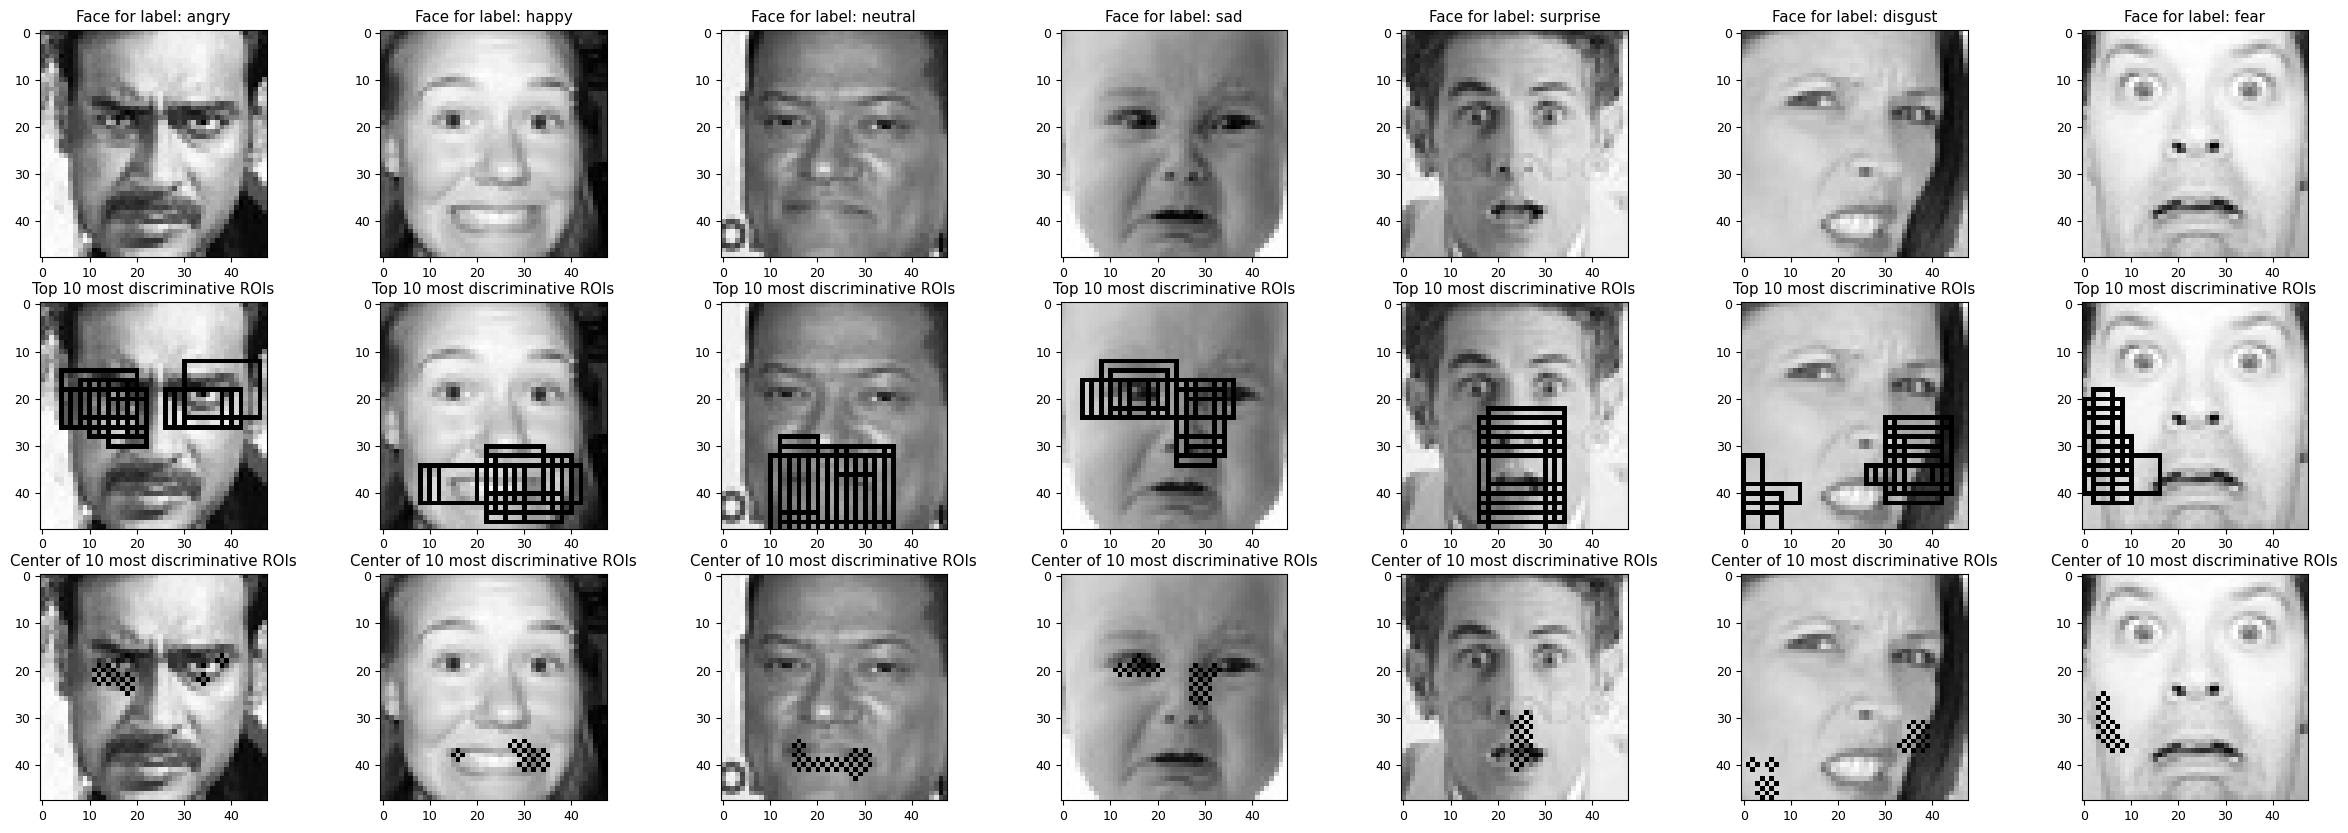

In [19]:
fig, ax = plt.subplots(3, 7, figsize=(30, 10))

for i, emotion in enumerate(image_by_emotion.keys()):
    image_emotion = Image.open(os.path.join(PATH_TRAIN, emotion, image_by_emotion[emotion]))
    image = np.asarray(image_emotion).copy()

    # Plot the face
    ax[0][i].imshow(image, cmap='gray')
    ax[0][i].set_title(f"Face for label: {emotion}")

    # Plot the face image and the bounding box of the top 10 most discriminative ROIs
    for j, (start_x, start_y, end_x, end_y) in enumerate(list(score_roi_by_emotion[emotion].keys())[:20]):
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 1)

    ax[1][i].imshow(image, cmap='gray')
    ax[1][i].set_title(f"Top 10 most discriminative ROIs")

    # Plot the center of top 50 ROIs 
    image_circle = np.array(image_emotion).copy()
    for (start_x, start_y, end_x, end_y) in list(score_roi_by_emotion[emotion].keys())[:20]:
        center_bbox = ((start_x+end_x)//2, (start_y+end_y)//2)
        cv2.circle(image_circle, center_bbox, 1, (0, 255, 0), 1)

    ax[2][i].imshow(image_circle, cmap='gray')
    ax[2][i].set_title(f"Center of 10 most discriminative ROIs")

ROIs vary greatly from one emotion to another. For example, eyes and eyebrows are predominant in the detection of the angry emotion, while the corners of the mouth are more discriminating for the happy emotion, and the circularity of the mouth for surprise. For some emotions, the results are inconclusive, indicating that there are no distinctive patterns between the different images of the class for this dataset.

In [20]:
N_TOP_ROI = 10

In [21]:
list_subregions = []
for emotion in score_roi_by_emotion.keys():
    list_subregions += list(score_roi_by_emotion[emotion].keys())[:N_TOP_ROI]

In [23]:
train_dataset = Dataset(PATH_TRAIN, 
                        max_samples=None, 
                        radius=1, 
                        numPoints=4, 
                        method="nri_uniform", 
                        subregion_type="manual", 
                        list_subregions=list_subregions)
train_dataset.load_data()
X_train, y_train = train_dataset.feature_vectors, train_dataset.labels

test_dataset = Dataset(PATH_TEST, 
                       max_samples=None, 
                       radius=1, 
                       numPoints=4, 
                       method="nri_uniform", 
                       subregion_type="manual", 
                       list_subregions=list_subregions)
test_dataset.load_data()
X_test, y_test = test_dataset.feature_vectors, test_dataset.labels

In [24]:
print("Number of training samples: ", len(X_train))
print("Number of testing samples: ", len(X_test))
print("Length of feature vector: ", len(X_train[0]))

Number of training samples:  28709
Number of testing samples:  7178
Length of feature vector:  1050


In [25]:
svc = SVC(class_weight='balanced', **PARAMS_SVC["nri_uniform"], verbose=True)
svc.fit(X_train, y_train)

[LibSVM].....*..*
optimization finished, #iter = 7769
obj = -1716.094263, rho = -0.681091
nSV = 2139, nBSV = 3
..........................*...........*
optimization finished, #iter = 37521
obj = -12899.095955, rho = 0.443985
nSV = 7137, nBSV = 101
.......................*...........*
optimization finished, #iter = 34352
obj = -11032.716912, rho = 0.374628
nSV = 7310, nBSV = 391
..........................*............*
optimization finished, #iter = 38528
obj = -13237.394603, rho = 0.509416
nSV = 7503, nBSV = 218
............................*............*
optimization finished, #iter = 40485
obj = -13995.921589, rho = 0.729601
nSV = 7825, nBSV = 190
................*.......*
optimization finished, #iter = 23602
obj = -7127.017861, rho = -0.074556
nSV = 5099, nBSV = 18
.....*..*
optimization finished, #iter = 7555
obj = -1682.903267, rho = 0.906096
nSV = 2132, nBSV = 1
....*..*
optimization finished, #iter = 6902
obj = -1441.633733, rho = 0.896998
nSV = 1997, nBSV = 0
....*...*
optimizati

SVC(C=10, class_weight='balanced', verbose=True)

In [26]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

       angry       0.37      0.40      0.38       958
     disgust       0.85      0.41      0.55       111
        fear       0.39      0.39      0.39      1024
       happy       0.65      0.71      0.68      1774
     neutral       0.44      0.44      0.44      1233
         sad       0.38      0.37      0.37      1247
    surprise       0.72      0.61      0.66       831

    accuracy                           0.50      7178
   macro avg       0.54      0.47      0.50      7178
weighted avg       0.50      0.50      0.50      7178



Text(71.72222222222221, 0.5, 'True')

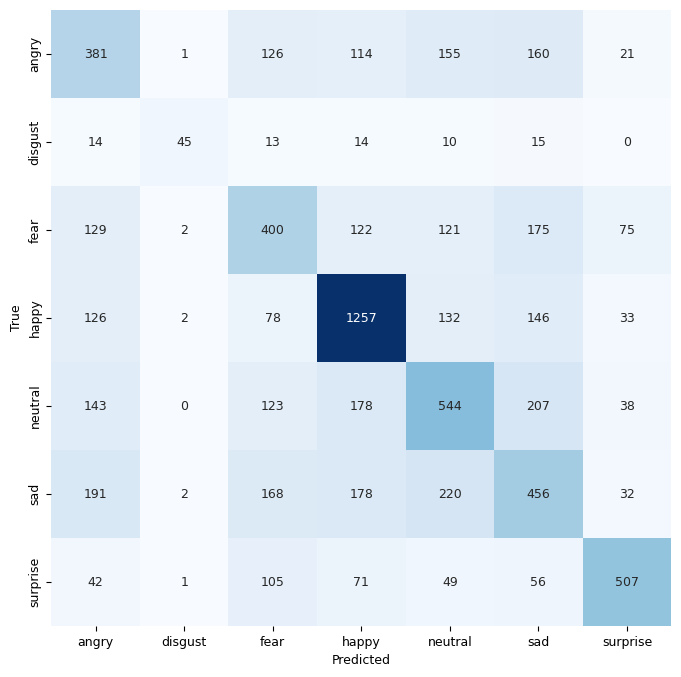

In [27]:
# Confusion matrix plot
cm = confusion_matrix(y_test, svc.predict(X_test))
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(7) + 0.5, ["angry", "disgust", "fear", "happy", "neutral","sad", "surprise"])
plt.yticks(np.arange(7) + 0.5, ["angry", "disgust", "fear", "happy", "neutral","sad", "surprise"])
plt.xlabel('Predicted')
plt.ylabel('True')

Overall, the results of this study are very satisfactory. Several observations can be drawn from the above results. 

As we have seen earlier, some emotions have very distinctive patterns such as happy, angry and surprised, but other emotions have no particular paterns... This translates into a rather unbalanced performance of our models on the different emotions. You can see that our classifier performs very well on happy and surprised emotions!

Finally, we can see that the selected regions are highly concentrated in one area of the image. This is due to the fact that the weak classifiers are trained on a single ROI each time, and can’t capture the discriminatory power of an association of several ROIs.

In [28]:
pickle.dump(svc, open("./results_roi_learning/svc_10_roi_emotion.pkl", "wb"))

## Approach 4: Use pretrained model to detect specify ROI of a face.

The idea here is to use a pre-trained model that is actually based on the method described in "One Millisecond Face Alignment with an Ensemble of Regression Trees" by Kazemi and Sullivan (2014).

This predictor uses an ensemble of regression trees to directly estimate facial landmark positions from pixel intensities in the image, without performing any prior feature extraction.

It is trained on a dataset comprising previously labeled facial landmarks, defining the specific coordinates (x, y) surrounding each facial structure (mouth, eyebrows, eyes, nose, etc.).

Once the ROIs on the face have been detected, we calculate the LBP histograms for each of the 8 regions and concatenate them to obtain our feature vector.

In [29]:
train_dataset = Dataset(PATH_TRAIN, 
                        max_samples=None, 
                        radius=2, 
                        numPoints=8, 
                        method="nri_uniform", 
                        subregion_type="face_parts", 
                        path_predictor="./shape_predictor_68_face_landmarks.dat")
train_dataset.load_data()
X_train, y_train = train_dataset.feature_vectors, train_dataset.labels


In [30]:
test_dataset = Dataset(PATH_TEST, 
                       max_samples=None, 
                       radius=2, 
                       numPoints=8, 
                       method="nri_uniform", 
                       subregion_type="face_parts", 
                       path_predictor="./shape_predictor_68_face_landmarks.dat")
test_dataset.load_data()
X_test, y_test = test_dataset.feature_vectors, test_dataset.labels

In [31]:
print("Number of training samples: ", len(X_train))
print("Number of testing samples: ", len(X_test))
print("Length of feature vector: ", len(X_train[0]))

Number of training samples:  28709
Number of testing samples:  7178
Length of feature vector:  472


In [32]:
svc = SVC(class_weight='balanced', **PARAMS_SVC["nri_uniform"])
svc.fit(X_train, y_train)

SVC(C=10, class_weight='balanced')

In [33]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

       angry       0.36      0.43      0.39       958
     disgust       0.56      0.44      0.49       111
        fear       0.36      0.33      0.35      1024
       happy       0.70      0.66      0.68      1774
     neutral       0.48      0.52      0.50      1233
         sad       0.38      0.34      0.36      1247
    surprise       0.68      0.72      0.70       831

    accuracy                           0.51      7178
   macro avg       0.50      0.49      0.50      7178
weighted avg       0.51      0.51      0.51      7178



Text(71.72222222222221, 0.5, 'True')

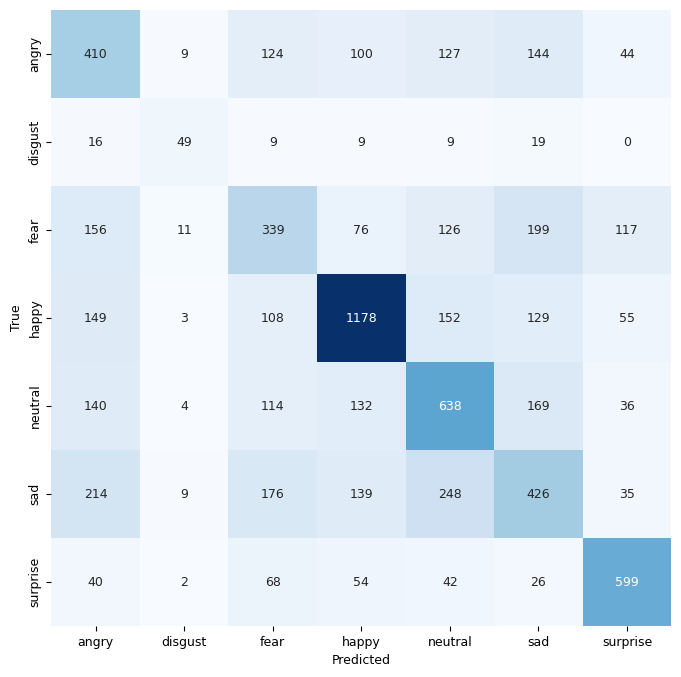

In [34]:
# Confusion matrix plot
cm = confusion_matrix(y_test, svc.predict(X_test))
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(7) + 0.5, ["angry", "disgust", "fear", "happy", "neutral","sad", "surprise"])
plt.yticks(np.arange(7) + 0.5, ["angry", "disgust", "fear", "happy", "neutral","sad", "surprise"])
plt.xlabel('Predicted') 
plt.ylabel('True')

In [35]:
os.makedirs("./results_face_parts", exist_ok=True)
pickle.dump(svc, open("./results_face_parts/svc.pkl", "wb"))

### Tuning the hyperparameters for this method

In [36]:
# Parameters that will be tested during the grid search
list_radius = [1, 1.5, 2]
list_numPoints = [4, 8, 12]

In [37]:
experiment_tracking_df = pd.DataFrame(columns=['id','radius', 'numPoints', 'method', "kwargs_param", 'macro_f1_score', "accuracy"])

In [41]:
id_experiment = 1
for radius, num_point in tqdm(itertools.product(list_radius, list_numPoints), total=len(list_radius)*len(list_numPoints)):
    # Load data
    train_dataset = Dataset(PATH_TRAIN, 
                            max_samples=MAX_SAMPLES_TRAIN, 
                            radius=radius, 
                            numPoints=num_point, 
                            method="nri_uniform", 
                            path_predictor="./shape_predictor_68_face_landmarks.dat", 
                            subregion_type="face_parts")
    train_dataset.load_data()
    X_train, y_train = train_dataset.feature_vectors, train_dataset.labels

    test_dataset = Dataset(PATH_TEST, 
                            max_samples=MAX_SAMPLES_TEST, 
                            radius=radius, 
                            numPoints=num_point, 
                            method="nri_uniform", 
                            path_predictor="./shape_predictor_68_face_landmarks.dat", 
                            subregion_type="face_parts")
    test_dataset.load_data()
    X_test, y_test = test_dataset.feature_vectors, test_dataset.labels

    # Train and predict
    svc = SVC(class_weight='balanced', **PARAMS_SVC["nri_uniform"])
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    macro_f1_score = f1_score(y_test, y_pred, average='macro')
    accuracy = svc.score(X_test, y_test)

    # Save all the classification report as txt file and save the major metrics in a dataframe
    report = classification_report(y_test, y_pred)
    with open(f"./results_face_parts/{id_experiment}.txt", "w") as f:
        f.write(report)
    experiment_tracking_df = pd.concat([experiment_tracking_df, 
                                        pd.DataFrame({"id":id_experiment, 
                                                      'radius': radius, 
                                                      'numPoints': num_point, 
                                                      'method': "nri_uniform", 
                                                      "kwargs_param": str(PARAMS_SVC["nri_uniform"]), 
                                                      'macro_f1_score': macro_f1_score, 
                                                      "accuracy": accuracy}, index=[0])], 
                                        ignore_index=True)
    id_experiment += 1

  0%|          | 0/9 [00:00<?, ?it/s]/var/folders/_s/grxhyczx135dcrhc7pzfhkxr0000gn/T/ipykernel_68341/1025569923.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  experiment_tracking_df = pd.concat([experiment_tracking_df,
100%|██████████| 9/9 [01:41<00:00, 11.30s/it]


In [42]:
experiment_tracking_df = experiment_tracking_df.sort_values(by="macro_f1_score", ascending=False)

In [43]:
experiment_tracking_df.head(10)

id radius numPoints       method                kwargs_param  \
4  5    1.5         8  nri_uniform  {'C': 10, 'kernel': 'rbf'}   
8  9      2        12  nri_uniform  {'C': 10, 'kernel': 'rbf'}   
1  2      1         8  nri_uniform  {'C': 10, 'kernel': 'rbf'}   
0  1      1         4  nri_uniform  {'C': 10, 'kernel': 'rbf'}   
7  8      2         8  nri_uniform  {'C': 10, 'kernel': 'rbf'}   
2  3      1        12  nri_uniform  {'C': 10, 'kernel': 'rbf'}   
5  6    1.5        12  nri_uniform  {'C': 10, 'kernel': 'rbf'}   
6  7      2         4  nri_uniform  {'C': 10, 'kernel': 'rbf'}   
3  4    1.5         4  nri_uniform  {'C': 10, 'kernel': 'rbf'}   

   macro_f1_score  accuracy  
4        0.390697  0.392567  
8        0.377955  0.379791  
1        0.374134  0.370499  
0        0.369640  0.365854  
7        0.369321  0.368177  
2        0.367349  0.362369  
5        0.365437  0.364692  
6        0.365033  0.367015  
3        0.359870  0.361208

In [44]:
experiment_tracking_df.to_csv("./results_face_parts/experiment_tracking.csv", index=False)

### Combining both facial LBP histograms to exhaustive grid based LBP histogrames (approach 2 + 4)

In [45]:
train_dli = Dataset(PATH_TRAIN, 
                    max_samples=None, 
                    radius=1.5, 
                    numPoints=4, 
                    method="nri_uniform", 
                    subregion_type="face_parts", 
                    path_predictor="./shape_predictor_68_face_landmarks.dat")
train_dli.load_data()
X_train_dli, y_train = train_dli.feature_vectors, train_dli.labels

test_dli = Dataset(PATH_TEST, 
                   max_samples=None,
                   radius=1.5, 
                   numPoints=4, 
                   method="nri_uniform", 
                   subregion_type="face_parts", 
                   path_predictor="./shape_predictor_68_face_landmarks.dat")
test_dli.load_data()
X_test_dli, y_test = test_dli.feature_vectors, test_dli.labels

In [46]:
train_grid = Dataset(PATH_TRAIN, 
                     max_samples=None, 
                     radius=1, 
                     numPoints=4, 
                     method="nri_uniform", 
                     subregion_type="grid", 
                     num_subregions=6)
train_grid.load_data()
X_train_grid, y_train_grid = train_grid.feature_vectors, train_grid.labels

test_grid = Dataset(PATH_TEST, 
                    max_samples=None, 
                    radius=1, 
                    numPoints=4, 
                    method="nri_uniform", 
                    subregion_type="grid", 
                    num_subregions=6)
test_grid.load_data()
X_test_grid, y_test_grid = test_grid.feature_vectors, test_grid.labels

In [47]:
X_train = [np.hstack([x1, x2]) for  x1, x2 in zip( X_train_dli, X_train_grid)]

In [48]:
X_test = [np.hstack([x1, x2]) for x1, x2 in zip(X_test_dli, X_test_grid)]

In [49]:
print("Number of training samples: ", len(X_train))
print("Number of testing samples: ", len(X_test))
print("Length of feature vector: ", len(X_train[0]))

Number of training samples:  28709
Number of testing samples:  7178
Length of feature vector:  660


In [50]:
svc = SVC(class_weight='balanced', **PARAMS_SVC["nri_uniform"])
svc.fit(X_train, y_train)

SVC(C=10, class_weight='balanced')

In [51]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

       angry       0.43      0.44      0.44       958
     disgust       0.88      0.45      0.60       111
        fear       0.46      0.40      0.43      1024
       happy       0.71      0.76      0.73      1774
     neutral       0.49      0.52      0.51      1233
         sad       0.43      0.43      0.43      1247
    surprise       0.77      0.71      0.74       831

    accuracy                           0.56      7178
   macro avg       0.60      0.53      0.55      7178
weighted avg       0.56      0.56      0.56      7178



In [52]:
os.makedirs("./results_combination", exist_ok=True)
pickle.dump(svc, open("./results_combination/svc.pkl", "wb"))

# Conclusion

### Compilation of results 

| R | P | Pattern Type | Approach          | Classifier | Accuracy |
|---|---|--------------|-------------------|------------|----------|
| 2 | 8 | Default      | Whole image      | SVM  | 0.30            |
| 1 | 8 | NRI          | Grid (6x6)       | SVM  | 0.58            |
| 1 | 4 | NRI          | 10 ROIs / emotion| SVM  | 0.54            |
| 1.5 | 4 | NRI          | Pretrained + 10 ROIs / emotion  | SVM  | 0.60       |



As we can see, the most efficient technique is still approach number 4, combining pretrained model to identify facial landmark positions and the top 10 ROIs by emotions. This method is interpretable given the fact we identify intuitive ROIs for almost all emotions.

The performance of our approaches varies greatly from one emotion to another. Below are the detailed results per emotion for approach number 4. These results are in line with the observation we made earlier. In fact, the emotions on which our model performs least well are those for which we were unable to identify discriminating ROIs. This means that patterns are harder to discern.

### Classification repport from the best approach

| Emotion   | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| angry     | 0.43      | 0.44   | 0.44     | 958     |
| disgust   | 0.88      | 0.45   | 0.60     | 111     |
| fear      | 0.46      | 0.40   | 0.43     | 1024    |
| happy     | 0.71      | 0.76   | 0.73     | 1774    |
| neutral   | 0.49      | 0.52   | 0.51     | 1233    |
| sad       | 0.43      | 0.43   | 0.43     | 1247    |
| surprise  | 0.77      | 0.71   | 0.74     | 831     |
| Accuracy  |           |        |          | 0.56    |
| Macro avg | 0.60      | 0.53   | 0.55     | 7178    |
| Weighted avg | 0.56   | 0.56   | 0.56     | 7178    |